In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire 
import prepare 
import summarize

# Data Acquisition & Preparation

In [48]:
df = acquire.get_all_data(use_cache=True)

In [49]:
df = prepare.prep_store_data(df)

In [6]:
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,01-Jan,2-Tue,10.92
2013-01-01 00:00:00+00:00,17,26.0,295813,3,Ducal,Ducal Refried Red Beans,1.16,88313590791,88313590791,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,30.16
2013-01-01 00:00:00+00:00,7,32.0,125995,10,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004,8503 NW Military Hwy,San Antonio,TX,78231,01-Jan,2-Tue,308.48
2013-01-01 00:00:00+00:00,18,45.0,314073,3,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,197.55
2013-01-01 00:00:00+00:00,19,34.0,332333,3,Careone,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,25.16


# Split train/test

Special considerations when sampling time-series data include: 

- The test sample must follow your train (in time) and cannot overlap the data that trained the model it will be used to test. 

- The test sample must be in a continous interval to maintain the aspect of the data being 'time-series'. That is, each point is not in isolation, but belongs between the points around it; therefore, it must be considered with the points around it. 

- The test sample ideally will follow the training data with a time gap between the two samples. 30 days is a standard recommended gap, but this obviously depends on the problem at hand.

Ways to split time-series data: 
- Sample using sklearn's Time Series cross-validator 
- Sample using a static date cutoff 
- Sample using a percent split

## Sklearn TimeSeriesSplit 
- provides train/test indices to split time series data samples that are observed at **fixed time intervals**, in train/test sets. 


- In each split, test indices must be higher than before 
> no shuffling in cross validator

- a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

In [8]:
# reset index (we need the index to represent row numbers for this method of splitting)
df2 = df.sale_amount.resample('D').sum().reset_index()
X = df2.sale_date
y = df2.sale_amount

1. **Create object** create TimeSeriesSplit to do 5 splits with no max train size. 
2. **Fit** generate the indices for the splits using tss.split(X). 
3. **Transform** use those indices to select the rows to go in their respective samples. 

In [9]:
tss = TimeSeriesSplit(n_splits=5, max_train_size=None)
for train_index, test_index in tss.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

### Confirm sklearn train/ test split range did not overlap

In [10]:
print(X_train.tail())
print(X_test.head())
print(X_test.tail())

1517   2017-02-26 00:00:00+00:00
1518   2017-02-27 00:00:00+00:00
1519   2017-02-28 00:00:00+00:00
1520   2017-03-01 00:00:00+00:00
1521   2017-03-02 00:00:00+00:00
Name: sale_date, dtype: datetime64[ns, GMT]
1522   2017-03-03 00:00:00+00:00
1523   2017-03-04 00:00:00+00:00
1524   2017-03-05 00:00:00+00:00
1525   2017-03-06 00:00:00+00:00
1526   2017-03-07 00:00:00+00:00
Name: sale_date, dtype: datetime64[ns, GMT]
1821   2017-12-27 00:00:00+00:00
1822   2017-12-28 00:00:00+00:00
1823   2017-12-29 00:00:00+00:00
1824   2017-12-30 00:00:00+00:00
1825   2017-12-31 00:00:00+00:00
Name: sale_date, dtype: datetime64[ns, GMT]


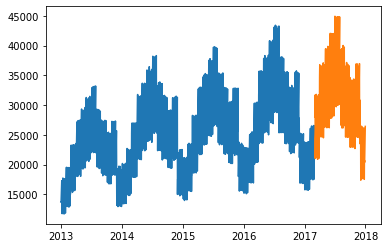

In [11]:
plt.plot(X_train, y_train)
plt.plot(X_test, y_test)

## Sampling using date cutoff

1. select from your dataframe (where date is index) using a date range.
2. set test to begin after the last train.
3. followed by resample and aggregate

In [12]:
aggregation = 'sum'

train = df[:'2016'].sale_amount.resample('D').agg(aggregation)
test = df['2017':].sale_amount.resample('D').agg(aggregation)

print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 1826
Training Observations: 1461
Testing Observations: 365


### Confirm cutoff range of train/ test did not overlap

In [13]:
pd.concat([train.head(3), train.tail(3)])

sale_date
2013-01-01 00:00:00+00:00    13696.0
2013-01-02 00:00:00+00:00    13678.0
2013-01-03 00:00:00+00:00    14488.0
2016-12-29 00:00:00+00:00    21111.0
2016-12-30 00:00:00+00:00    22296.0
2016-12-31 00:00:00+00:00    23792.0
Name: sale_amount, dtype: float64

In [14]:
pd.concat([test.head(3), test.tail(3)])

sale_date
2017-01-01 00:00:00+00:00    23709.0
2017-01-02 00:00:00+00:00    15772.0
2017-01-03 00:00:00+00:00    18650.0
2017-12-29 00:00:00+00:00    23535.0
2017-12-30 00:00:00+00:00    24988.0
2017-12-31 00:00:00+00:00    26420.0
Name: sale_amount, dtype: float64

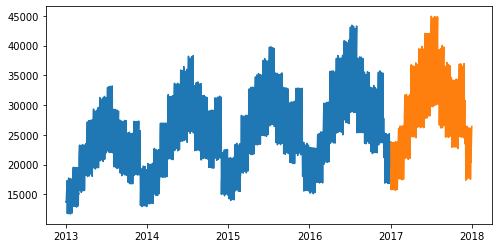

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(train) # we can also run it as: train.plot() and test.plot()
plt.plot(test)
plt.show()

## Sampling using percent split
1. Set your train size, in terms of percent, e.g. 66%
2. Compute the row number that equates to the percentage point of your data.
3. For example, at row x, 66% of the data is up to row x, and 34% is x and beyond.
4. Use indexing to select from your dataframe rows 0:x for train.
5. Test will go from x to the last row in the dataframe.

In [16]:
aggregation = 'sum'

ts_data = df.sale_amount.resample('D').agg(aggregation)

In [17]:
train_size = int(len(ts_data) * 0.66)
train1, test1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train1)))
print('Testing Observations: %d' % (len(test1)))

Observations: 1826
Training Observations: 1205
Testing Observations: 621


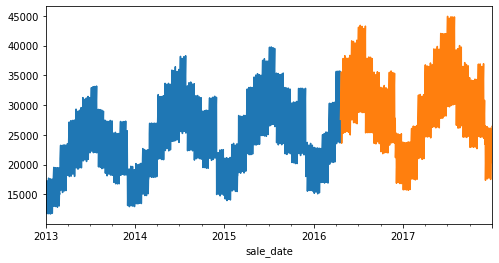

In [18]:
plt.figure(figsize=(8, 4))
train1.plot()
test1.plot()
plt.show()

# Visualize Time Series Data

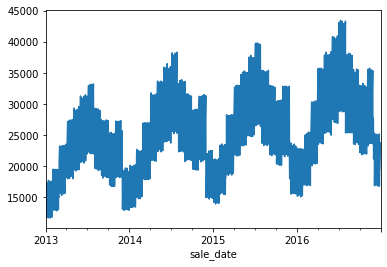

In [19]:
# Daily Average (or Total)
# Our data is already at the daily level, so no new resampling is required.

train.plot()
plt.show()

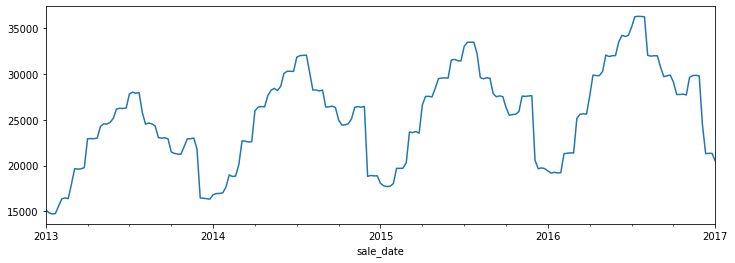

In [20]:
train.resample('W').mean().plot(figsize=(12, 4)) # weekly average
plt.show()

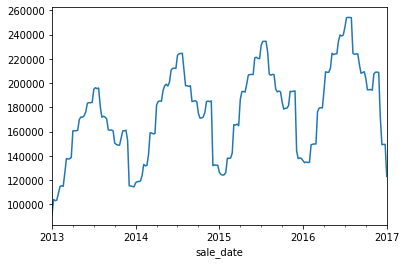

In [21]:
train.resample('W').sum().plot() # weekly total
plt.show()

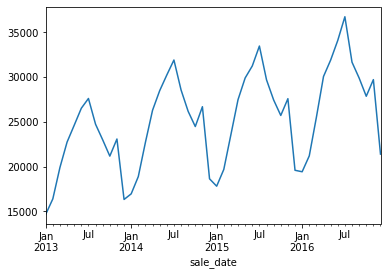

In [22]:
# monthly, MS = month start
train.resample('MS').mean().plot()
plt.show()


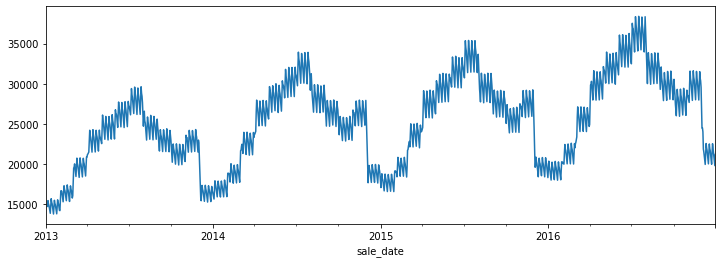

In [23]:
# moving average
train.rolling(5).mean().plot(figsize=(12, 4))
plt.show()

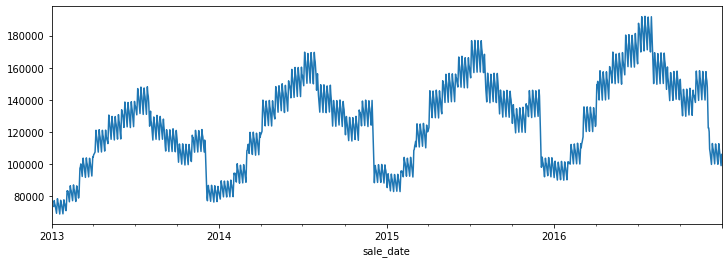

In [24]:
train.rolling(5).sum().plot(figsize=(12, 4))
plt.show()

## Moving Difference 5*

more useful in exploration and reduce some noise is to resample at a lower frequency (e.g. weekly),

In [26]:
train.resample('W').mean().diff(periods=1)

sale_date
2013-01-06 00:00:00+00:00            NaN
2013-01-13 00:00:00+00:00    -334.690476
2013-01-20 00:00:00+00:00    -136.000000
2013-01-27 00:00:00+00:00      49.714286
2013-02-03 00:00:00+00:00     818.428571
2013-02-10 00:00:00+00:00     791.285714
2013-02-17 00:00:00+00:00      99.285714
2013-02-24 00:00:00+00:00     -70.714286
2013-03-03 00:00:00+00:00    1578.571429
2013-03-10 00:00:00+00:00    1698.428571
2013-03-17 00:00:00+00:00     -57.142857
2013-03-24 00:00:00+00:00      31.714286
2013-03-31 00:00:00+00:00     140.857143
2013-04-07 00:00:00+00:00    3150.000000
2013-04-14 00:00:00+00:00      17.142857
2013-04-21 00:00:00+00:00      -8.571429
2013-04-28 00:00:00+00:00      65.428571
2013-05-05 00:00:00+00:00    1264.428571
2013-05-12 00:00:00+00:00     298.571429
2013-05-19 00:00:00+00:00     -28.142857
2013-05-26 00:00:00+00:00     176.571429
2013-06-02 00:00:00+00:00     452.000000
2013-06-09 00:00:00+00:00    1021.142857
2013-06-16 00:00:00+00:00      70.000000
2013-0

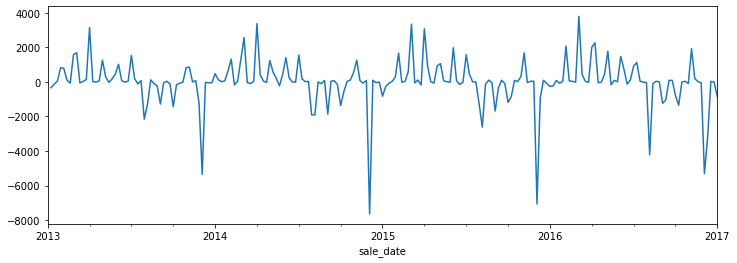

In [25]:
train.resample('W').mean().diff(periods=1).plot(figsize=(12,4))

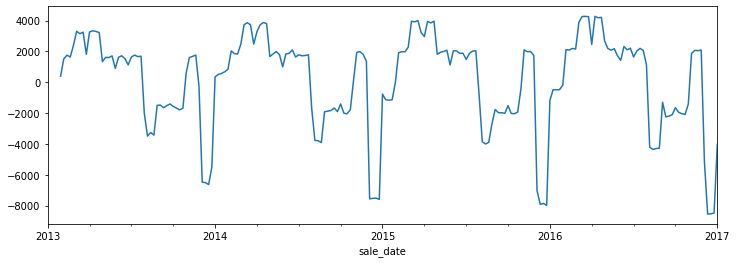

In [27]:
# diff every four weeks
train.resample('W').mean().diff(periods=4).plot(figsize=(12,4))

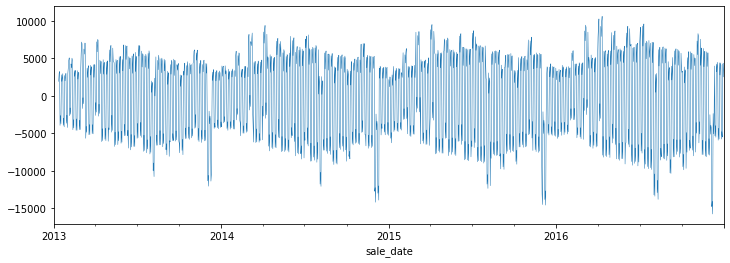

In [28]:
# diff every 10 days
train.diff(periods=10).plot(figsize=(12, 4), linewidth=0.5)

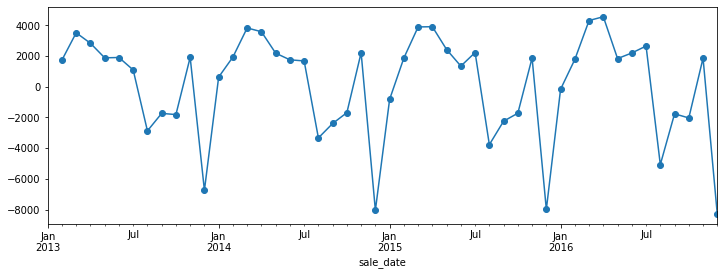

In [29]:
# month over month
train.resample('MS').mean().diff(periods=1).plot(figsize=(12,4), marker='o', linestyle='-')


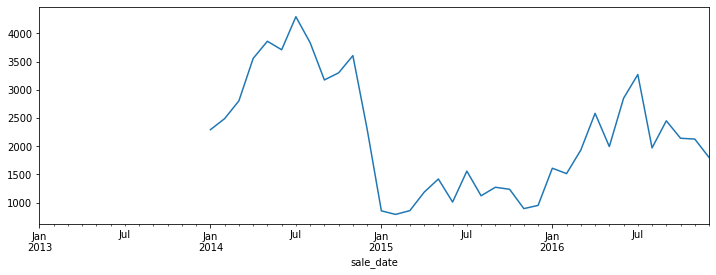

In [30]:
# year over year
train.resample('MS').mean().diff(periods=12).plot(figsize=(12,4))
plt.show()

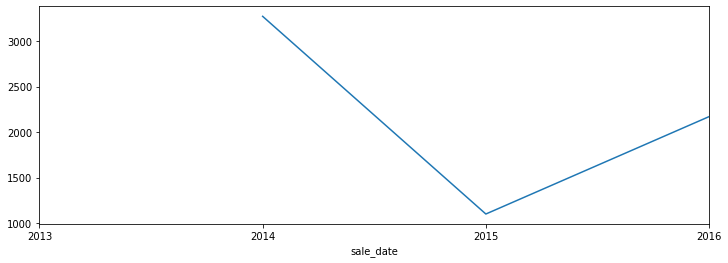

In [31]:
# Year over year, with only 1 data point each year

train.resample('Y').mean().diff(periods=1).plot(figsize=(12,4))
plt.show()

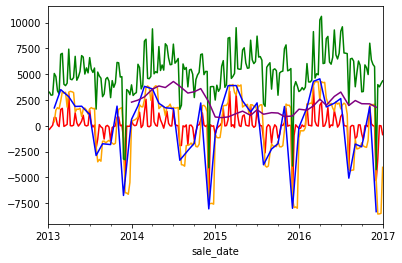

In [32]:
train.resample('W').mean().diff(periods=1).plot(color='red')
train.resample('W').mean().diff(periods=4).plot(color='orange')
train.diff(periods=10).plot(color='green')
train.resample('MS').mean().diff(periods=1).plot(color='blue')
train.resample('MS').mean().diff(periods=12).plot(color='purple')

## Customize Datetime Axis

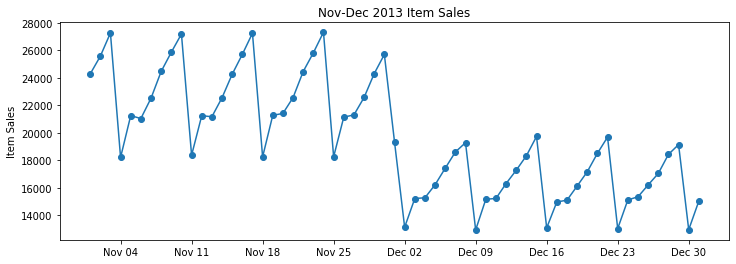

In [33]:
import matplotlib.dates as mdates

train_df = pd.DataFrame(train)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(train_df.loc['2013-11':'2013-12', 'sale_amount'], marker='o', linestyle='-')
ax.set_ylabel('Item Sales')
ax.set_title('Nov-Dec 2013 Item Sales')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## Seasonality
Group the sales time series by day of the week, to explore **weekly seasonality**.

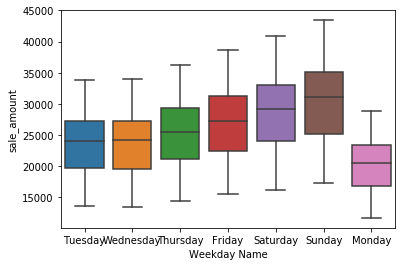

In [34]:
train_df['Weekday Name'] = train_df.index.weekday_name
sns.boxplot(data=train_df, x='Weekday Name', y='sale_amount');

## Merge time frequencies into same plot
compare the daily and weekly frequencies in the same plot.

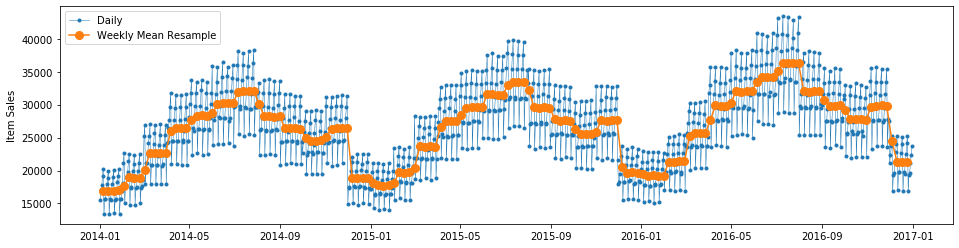

In [35]:
# Start and end of the date range to extract
start, end = '2014-01', '2016-12'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(train_df.loc[start:end, 'sale_amount'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(train_df.resample('W').mean().loc[start:end, 'sale_amount'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Item Sales')
ax.legend();

## Time-series decomposition: separate pieces of time series data
- (excluding actual values)
- trend 
- seasonality 
- noise (residuals)

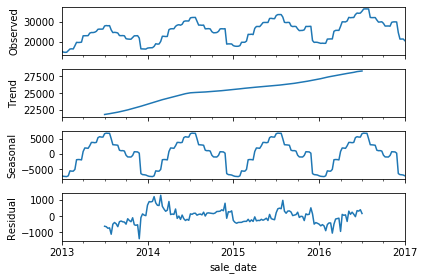

In [36]:
decomposition = sm.tsa.seasonal_decompose(train.resample('W').mean(), model='additive')

fig = decomposition.plot()
plt.show()

# Analyze Lag

**Lag** measuring one value against the previous or next value. 

**Methods:**
1. **plot y(t) x y(t+1): plot difference**
> e.g. compare 'today's sales vs. tomorrow's sales'

If your data is sampled daily

you could think of t as 'today'

t+1 is 'tomorrow'

In reality, t is any given day and t+1 is the day after.

If your data is sampled weekly

t is any given week

t+1 is the following week

2. **pearson's correlation coefficient**
>test correlation of yesterday vs. today, 
>
> e.g. We do this by creating a lagged version of the dataset and calculating a correlation matrix of each column with the other columns, including itself.

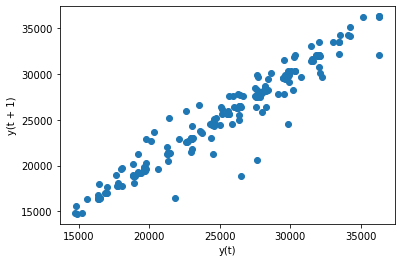

In [37]:
pd.plotting.lag_plot(train.resample('W').mean(), lag=1)

In [38]:
df_corr = pd.concat([train.shift(1), train], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.74914
t+1  0.74914  1.00000


# Exercise walkthrough

In [39]:
import itertools

In [41]:
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,01-Jan,2-Tue,10.92
2013-01-01 00:00:00+00:00,17,26.0,295813,3,Ducal,Ducal Refried Red Beans,1.16,88313590791,88313590791,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,30.16
2013-01-01 00:00:00+00:00,7,32.0,125995,10,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004,8503 NW Military Hwy,San Antonio,TX,78231,01-Jan,2-Tue,308.48
2013-01-01 00:00:00+00:00,18,45.0,314073,3,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,197.55
2013-01-01 00:00:00+00:00,19,34.0,332333,3,Careone,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,25.16


In [44]:
df.shape

(913000, 16)

In [50]:
target_vars = ['sales_total']

In [51]:
df = df[target_vars].resample('D').sum()

In [52]:
df.shape

(1826, 1)

In [62]:
y = df['sales_total']
X = df.index

In [63]:
# if deal with large amount of data
tss = TimeSeriesSplit(n_splits = 5, max_train_size = None)

IndexError: index 306 is out of bounds for axis 0 with size 304

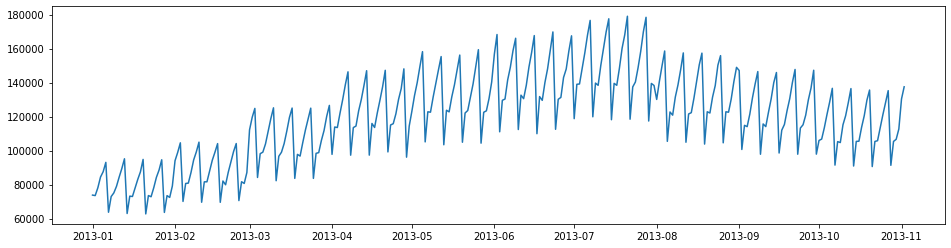

In [66]:
# call split to show indecies after split
train_indices = []
test_indices = []
for train_index, test_index in tss.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_indices.append(train_index)
    test_indices.append(test_index)
for i in range(0,5):
    plt.figure(figsize = (16,4))
    plt.plot(X_train[train_indices[i]],y_train[train_indices[i]])
    plt.plot(X_test[test_indices[i]], y_test[test_indices[i]])

In [60]:
train_indices

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [61]:
X_train.shape

(1522,)

In [65]:
for i in range(0,5):
    print(len(train_indices[i]))
    print(len(test_indices[i]))
    print(len(test_indices[i])/ (len(train_indices[i])+ len(test_indices[i])))

306
304
0.49836065573770494
610
304
0.33260393873085337
914
304
0.24958949096880131
1218
304
0.19973718791064388
1522
304
0.1664841182913472


In [71]:
print('Observations: %d' % (len(train.values) +len(test.values)))
print('Observations: %d' % (len(train.values)))
print('Observations: %d' % (len(test.values)))

Observations: 1826
Observations: 1461
Observations: 365


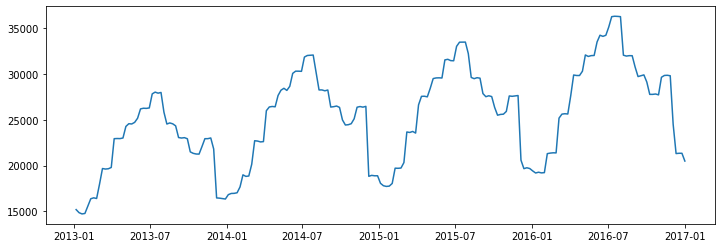

In [72]:
plt.figure(figsize = (12,4))
plt.plot(train.resample('W').mean())

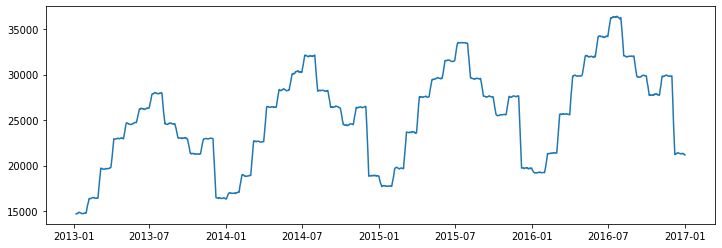

In [70]:
plt.figure(figsize = (12,4))
plt.plot(train.rolling(7).mean())

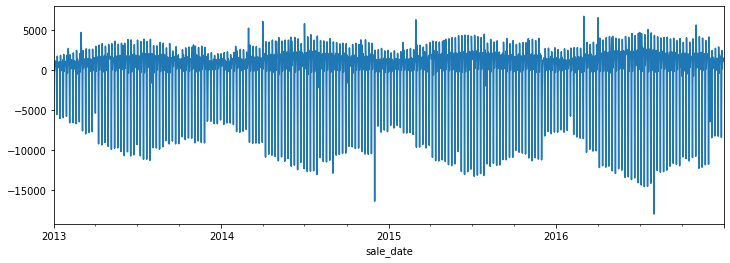

In [75]:
plt.figure(figsize = (12,4))
train.diff(periods = 1).plot()

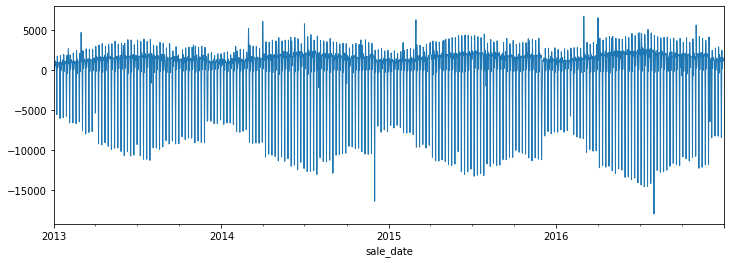

In [77]:
train.diff(periods = 1).plot(figsize = (12,4), linewidth = 1)

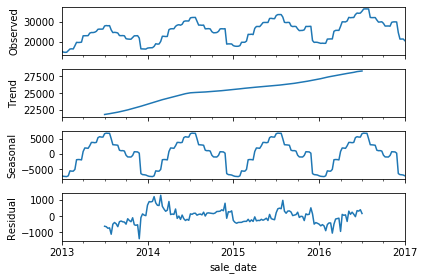

In [79]:
decomp = sm.tsa.seasonal_decompose(train.resample('W').mean(), model = 'additive')
fig = decomp.plot()
plt.show()

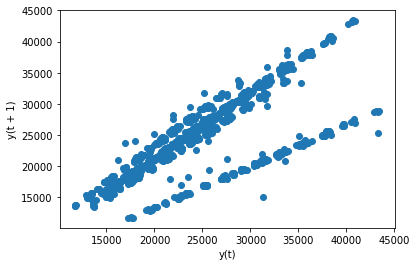

In [80]:
# compare today and tomorrow
pd.plotting.lag_plot(train.resample('D').mean(), lag = 1)

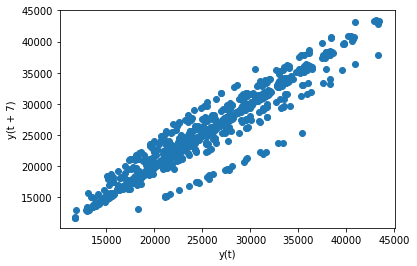

In [84]:
# lag 7 = , very correlated because comparing same date of the week
pd.plotting.lag_plot(train.resample('D').mean(), lag = 7)

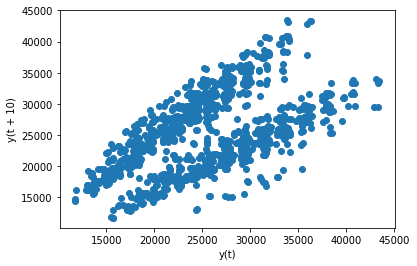

In [83]:
# lag = 10, won't be as correlated
pd.plotting.lag_plot(train.resample('D').mean(), lag = 10)

In [81]:
#.shift(1) same as lag = 1 above
df.corr = pd.concat([train.shift(1), train], axis = 1)
df.corr.columns = ['t-1', 't+1']
result = df_corr.corr()

In [82]:
# today is 74.9% explained by yesterday

result

,t-1,t+1
t-1,1.00000,0.74914
t+1,0.74914,1.00000


In [85]:
ops = acquire.get_opsd_data(use_cache=True)

In [86]:
ops.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [87]:
ops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
Date           4383 non-null object
Consumption    4383 non-null float64
Wind           2920 non-null float64
Solar          2188 non-null float64
Wind+Solar     2187 non-null float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [89]:
# important to resample, just to be sure
ops['date'] = pd.to_datetime(ops['Date'])
ops = ops.set_index('date').resample('D').sum()

In [91]:
ops.head()

,Consumption,Wind,Solar,Wind+Solar
date,,,,
2006-01-01,1069.184,0.0,0.0,0.0
2006-01-02,1380.521,0.0,0.0,0.0
2006-01-03,1442.533,0.0,0.0,0.0
2006-01-04,1457.217,0.0,0.0,0.0
2006-01-05,1477.131,0.0,0.0,0.0


In [93]:
train_size = int(len(ops) *0.7)

In [98]:
train, test = ops[:train_size], ops[train_size:]

In [99]:
len(train), len(test)

(3068, 1315)

In [100]:
# data integrity, check if split was correct
len(train)/ len(train+test)

0.6999771845767739

In [101]:
train.tail()

,Consumption,Wind,Solar,Wind+Solar
date,,,,
2014-05-22,1459.234,112.809,185.338,298.147
2014-05-23,1429.832,56.471,119.220,175.691
2014-05-24,1199.258,32.656,140.007,172.663
2014-05-25,1089.246,34.690,193.159,227.849
2014-05-26,1429.811,138.365,137.176,275.541


In [102]:
test.head()

,Consumption,Wind,Solar,Wind+Solar
date,,,,
2014-05-27,1464.019,189.127,70.470,259.597
2014-05-28,1441.622,189.686,60.001,249.687
2014-05-29,1128.151,76.746,83.043,159.789
2014-05-30,1261.208,59.239,138.099,197.338
2014-05-31,1147.440,105.023,189.115,294.138


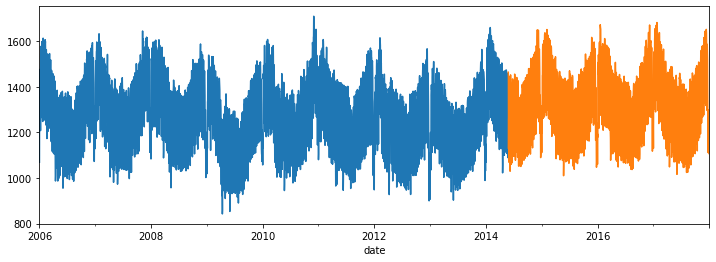

In [103]:
train.Consumption.plot(figsize = (12,4))
test.Consumption.plot(figsize = (12,4))

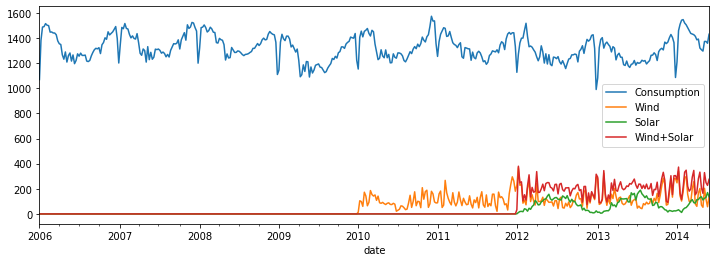

In [104]:
# limit/nature of data
# seasonality
train.resample('W').mean().plot(figsize = (12,4))

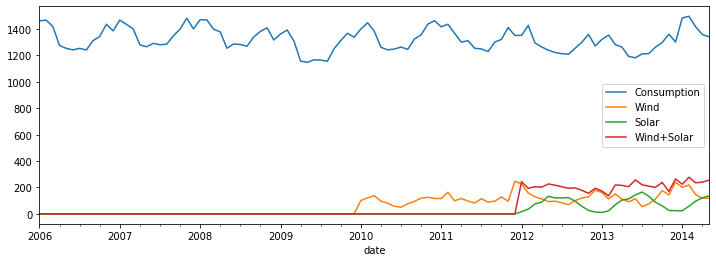

In [105]:
train.resample('MS').mean().plot(figsize = (12,4))

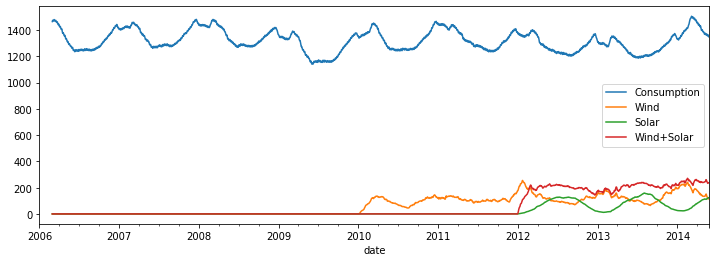

In [106]:
# smoothing,
train.rolling(60).mean().plot(figsize = (12,4))

In [107]:
ops['month'] = ops.index.month

In [109]:
ops.head(1)

,Consumption,Wind,Solar,Wind+Solar,month
date,,,,,
2006-01-01,1069.184,0.0,0.0,0.0,1


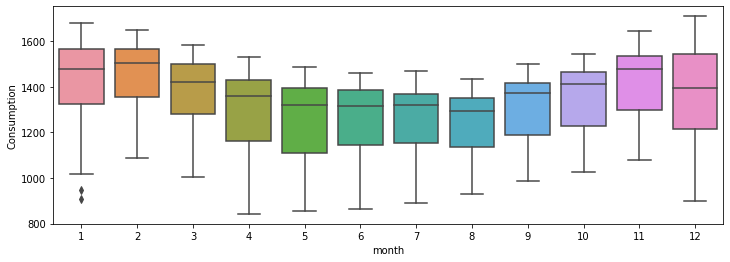

In [110]:
# definitely some trend
plt.figure(figsize = (12,4))
sns.boxplot(data = ops, x = 'month', y = 'Consumption')

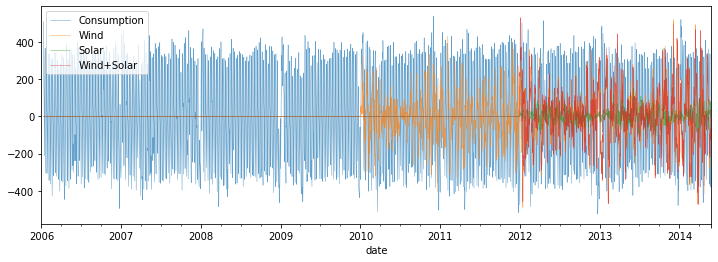

In [112]:
train.diff(periods = 10).plot(figsize = (12,4), alpha = 0.7, linewidth = 0.5)

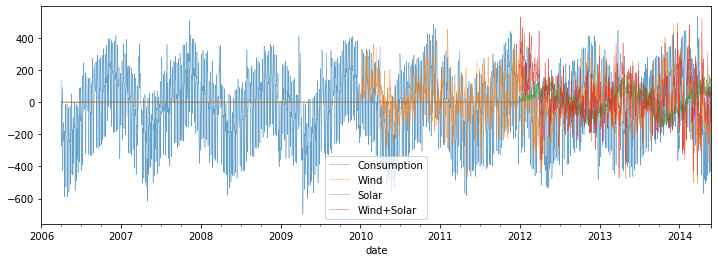

In [114]:
train.diff(periods = 90).plot(figsize = (12,4), alpha = 0.7, linewidth = 0.5)

In [119]:
# observed = trend + seasonal + residual
decomposition = sm.tsa.seasonal_decompose(train.Consumption.resample('W').mean(), model = 'additive')

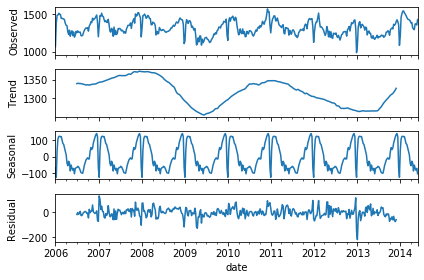

In [121]:
decomposition.plot()
plt.show()

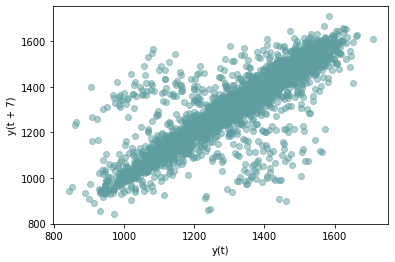

In [126]:
pd.plotting.lag_plot(train.Consumption, lag = 7, c = 'cadetblue', alpha = 0.5)